# INDONESIAN DAIRY EFFICIENCY ANALYSIS

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Set visualization style
sns.set_theme(style='whitegrid')

## 1. Reading the data

In [127]:
df_prod = pd.read_csv('Production.csv', delimiter=';')
df_herd = pd.read_csv('Herd Population.csv', delimiter=',')

df_prod.head()

,Provinsi,2024,2023,2022,2021,2020
0,ACEH,10.03,1.8,1.8,0.00,9.07
1,SUMATERA UTARA,8015.13,9234.4,8953.3,8745.02,3566.16
2,SUMATERA BARAT,676.21,965.7,822.1,827.58,1024.55
3,RIAU,41.05,29.2,28.6,36.73,45.37
4,JAMBI,0.00,3.9,3.9,3.94,6.26


In [128]:
df_herd.head()

,Provinsi,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015
0,Aceh,11,0,19,28,19,19,35,50,62,62
1,Sumatera Utara,"4,733","4,350","5,287","5,164","4,953","4,847","2,565","1,948","1,163","1,078"
2,Sumatera Barat,612,590,744,749,751,682,712,830,891,849
3,Riau,89,117,53,68,84,100,84,92,146,140
4,Jambi,6,4,15,14,18,27,30,33,30,30


## 2. Data Cleaning and Wrangling (Wide to Long Format)

In [100]:
# I should change the data format from Wide Format (Years as columns) to Long Format (a single Year column)

def clean_and_melt(df, value_name):
    # 1. Rename the province column (it was 'Unnamed: 0' in the production file)
    if 'Unnamed: 0' in df.columns:
        df = df.rename(columns={'Unnamed: 0': 'Provinsi'})
    
    # 2. Identify year columns (assuming columns that are not 'Provinsi' are years)
    year_cols = [col for col in df.columns if col not in ['Provinsi', '38 Provinsi', '...']]
    
    # 3. Clean and convert numeric columns (especially for herd data with commas)
    for col in year_cols:
        # Remove commas and convert to float, coercing errors (like text/symbols) to NaN
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # 4. Melt the DataFrame
    df_long = df.melt(
        id_vars=['Provinsi'],
        value_vars=year_cols,
        var_name='Year',
        value_name=value_name
    )
    
    # 5. Final cleaning for merge keys
    df_long['Year'] = df_long['Year'].astype(int)
    # Convert province names to uppercase to ensure consistent merging (e.g., 'Aceh' vs 'ACEH')
    df_long['Provinsi'] = df_long['Provinsi'].str.upper()
    return df_long

# Apply the function to both DataFrames
df_prod_long = clean_and_melt(df_prod.copy(), 'Produksi_Susu_Tons')
df_herd_long = clean_and_melt(df_herd.copy(), 'Total_Sapi_Perah')

# --- Merge ---
# Combine the two cleaned tables on the shared keys: Province and Year
df_annual = pd.merge(
    df_prod_long,
    df_herd_long,
    on=['Provinsi', 'Year'],
    how='inner'
)

## 3. Core Feature Engineering and Data Cleaning
This is the most critical analytical step, where I create the *efficiency metric* and the *growth metrics*.

In [101]:
# --- 3.1 Data Cleaning (Removing Zero/NaN Issues) ---
# Filter out unreliable data where the cow population is too small (e.g., < 10)
# This prevents division by near-zero, which leads to 'inf' or highly inaccurate yield numbers.
df_annual_clean = df_annual[df_annual['Total_Sapi_Perah'] >= 10].copy()
df_annual_clean.dropna(subset=['Produksi_Susu_Tons', 'Total_Sapi_Perah'], inplace=True)

# --- 3.2 Efficiency Metric ---
# Yield (Efficiency) is Production (Tons) / Herd Population (Head)
df_annual_clean['Yield_per_Cow'] = df_annual_clean['Produksi_Susu_Tons'] / df_annual_clean['Total_Sapi_Perah']

# --- 3.3 Growth Metrics ---
# Must sort first to ensure .pct_change() compares adjacent years within the same province
df_annual_clean = df_annual_clean.sort_values(by=['Provinsi', 'Year'])

# Calculate Annual Percentage Change for the three key metrics
# The .groupby('Provinsi') is essential: it resets the change calculation for each new province.
df_annual_clean['Yield_Growth_Pct'] = df_annual_clean.groupby('Provinsi')['Yield_per_Cow'].pct_change()
df_annual_clean['Herd_Growth_Pct'] = df_annual_clean.groupby('Provinsi')['Total_Sapi_Perah'].pct_change()
df_annual_clean['Production_Growth_Pct'] = df_annual_clean.groupby('Provinsi')['Produksi_Susu_Tons'].pct_change()

## 4. Data Analysis and Visualization

### A. National Efficiency Trend (Line Plot)

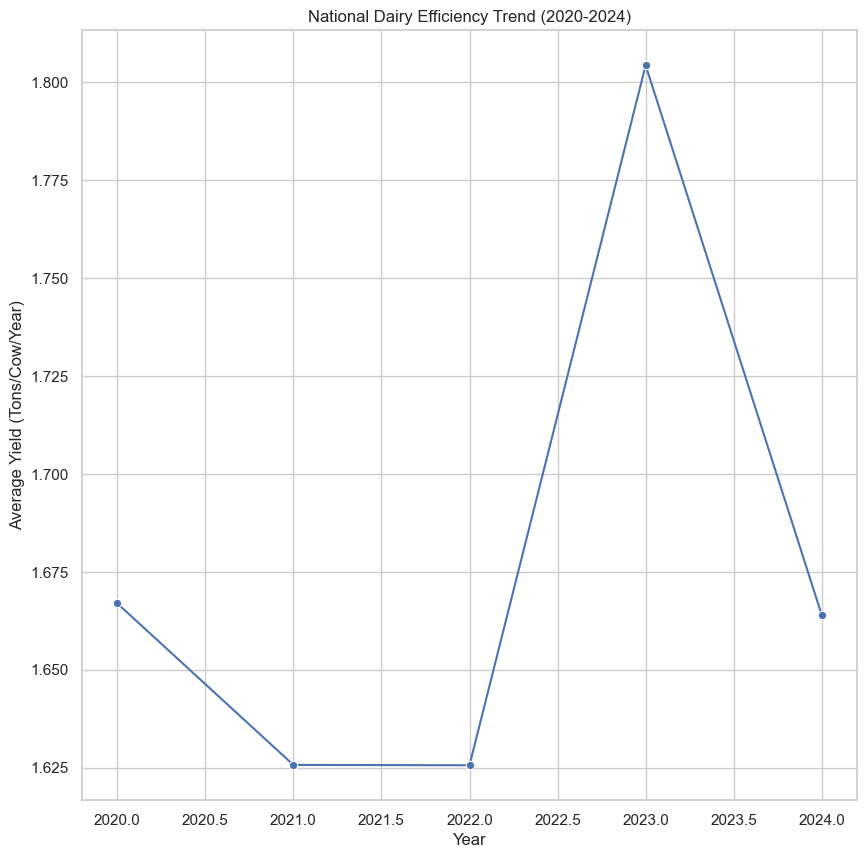

In [102]:
# Calculate National Totals
df_national = df_annual_clean.groupby('Year').agg(
    National_Yield=('Produksi_Susu_Tons', 'sum'),
    National_Herd=('Total_Sapi_Perah', 'sum')
).reset_index()
df_national['National_Yield_per_Cow'] = df_national['National_Yield'] / df_national['National_Herd']

plt.figure(figsize=(10, 10))
sns.lineplot(data=df_national, x='Year', y='National_Yield_per_Cow', marker='o')
plt.title('National Dairy Efficiency Trend (2020-2024)')
plt.ylabel('Average Yield (Tons/Cow/Year)')
plt.xlabel('Year')
plt.show()
#

### B. Provincial Efficiency Ranking (Sorted Bar Chart)

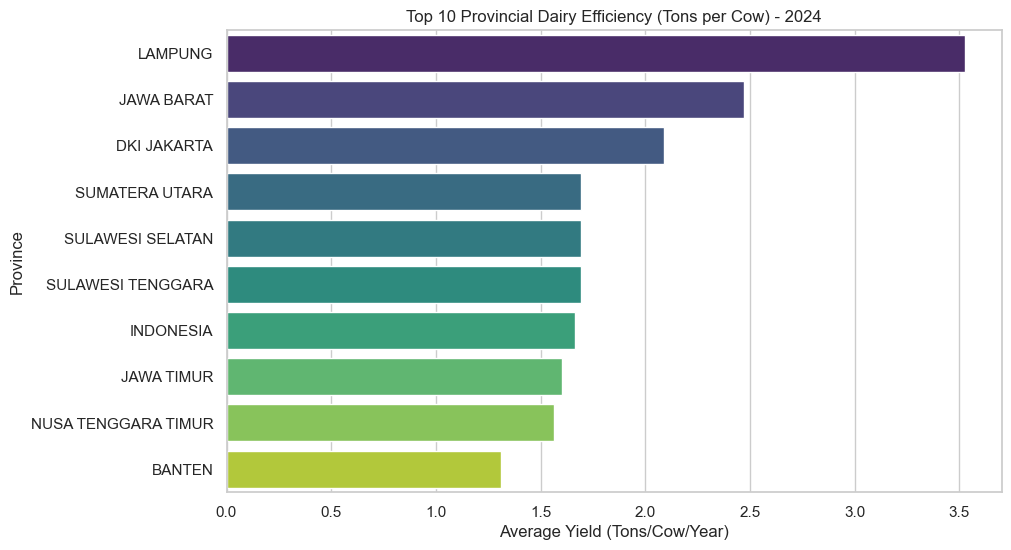

In [103]:
# I want to show from latest year, and sort t he province out

df_2024 = df_annual_clean[df_annual_clean['Year'] == 2024].sort_values(by='Yield_per_Cow', ascending=False)
top_10_2024 = df_2024.head(10)

plt.figure(figsize=(10, 6))

# I'm assigning the variables (Province) to hue, and hide the legend
sns.barplot(x='Yield_per_Cow', y='Provinsi', data=top_10_2024, hue='Provinsi', palette='viridis', legend=False)
plt.title('Top 10 Provincial Dairy Efficiency (Tons per Cow) - 2024')
plt.xlabel('Average Yield (Tons/Cow/Year)')
plt.ylabel('Province')
plt.show()
#

### C. Performance Matrix (Scatter Plot)
This plot calculate the _average annual growth_ over entire 2020-2024 period

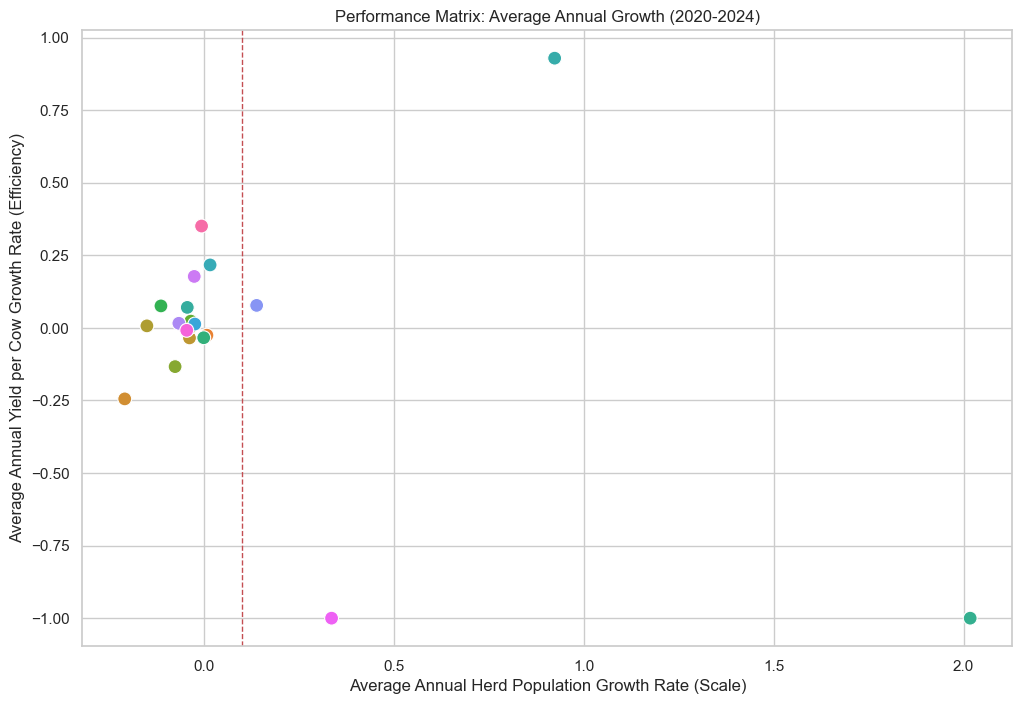

In [105]:
# Find the average
df_avg_growth = df_annual_clean.groupby('Provinsi').agg(
    Avg_Herd_Growth=('Herd_Growth_Pct', 'mean'),
    Avg_Yield_Growth=('Yield_Growth_Pct', 'mean')).reset_index()

# Find national's average
national_avg_herd_growth = df_avg_growth['Avg_Herd_Growth'].mean()
national_avg_yield_growth = df_avg_growth['Avg_Yield_Growth'].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Avg_Herd_Growth', y='Avg_Yield_Growth', data=df_avg_growth, hue='Provinsi', s=100, legend=False)

# Add quadrant lines and labels
plt.axvline(x=national_avg_herd_growth, color='r', linestyle='--', linewidth=1)
plt.axhline(y=national_avg_yield_growth, color='b', linestyle='--', linewidth=1)
plt.title('Performance Matrix: Average Annual Growth (2020-2024)')
plt.xlabel('Average Annual Herd Population Growth Rate (Scale)')
plt.ylabel('Average Annual Yield per Cow Growth Rate (Efficiency)')

# Add quadrant labels (simplified for documentation)
plt.text(national_avg_herd_growth * 1.05, national_avg_yield_growth * 0.95, 'Winners', fontsize=12, color='g', weight='bold')
plt.text(national_avg_herd_growth * 0.95, national_avg_yield_growth * 1.05, 'Efficiency Masters', fontsize=12, color='darkorange', weight='bold', ha='right')

plt.show()
#

## National Milk Production Projection (2020-2029)


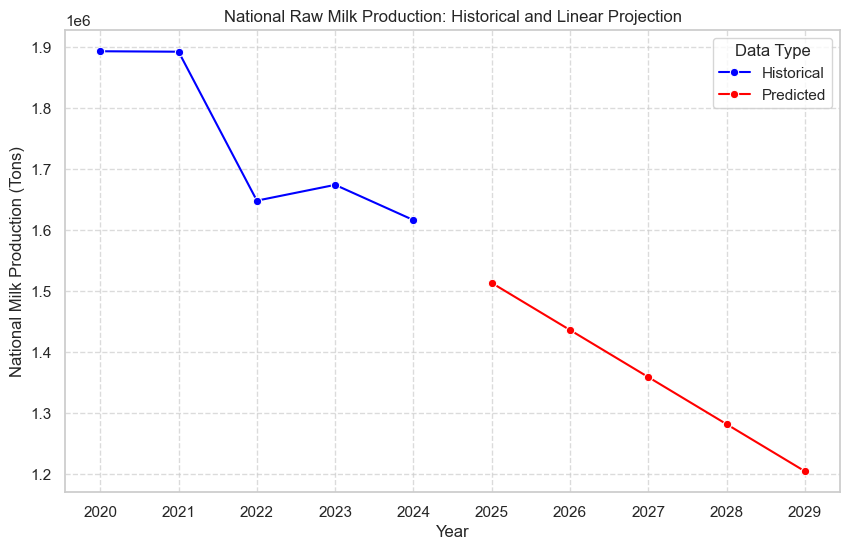

In [106]:
# Assuming df_national (Historical) and future_years (Predicted) are ready

# 1. Combine historical data with predicted data
df_plot = pd.concat([
    df_national.rename(columns={'National_Yield': 'Yield'}),
    future_years.rename(columns={'Predicted_Yield': 'Yield'})
], ignore_index=True)

# 2. Add a column to distinguish historical vs. predicted data
df_plot['Type'] = np.where(df_plot['Year'] <= df_national['Year'].max(), 'Historical', 'Predicted')

# 3. Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='Year', y='Yield', hue='Type', marker='o', palette={'Historical': 'blue', 'Predicted': 'red'})
plt.title('National Raw Milk Production: Historical and Linear Projection')
plt.ylabel('National Milk Production (Tons)')
plt.xlabel('Year')
plt.legend(title='Data Type')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df_plot['Year']) # Show all years on the axis
plt.show()

**_how accurate this model?_**

I also attach the code to check accuracy level of this model, below

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Independent variable (Feature): Year
X = df_national[['Year']]
# Dependent variable (Target): National Yield
y = df_national['National_Yield']

# 1. Train the model
model = LinearRegression()
model.fit(X, y)

# 2. Predict the yield for the historical years (2020-2024)
y_pred = model.predict(X)

# 3. Calculate the R-squared score by comparing the actual (y) to the predicted (y_pred)
r_squared = r2_score(y, y_pred)

print(f"R-squared (Coefficient of Determination): {r_squared:.4f}")

R-squared (Coefficient of Determination): 0.7985


** **

_It show a good fit and accuracy, but I think it missed something core and principal_

While the model showing almost **80%** accuracy, but it sounds pesimistic.
This happened because my model only use data range from 2020-2024, which most possibly disrupted with
post-COVID19 situation. Because of this, I will improve the data with wider time_range, and revise the
analysis.

## Holistic Dairy Production Data Analysis Pre-COVID (2015-2019) & Post-COVID (2020-2024)

In [136]:
# Define file names
PRODUCTION_FILE = 'Production(1).csv'
HERD_FILE = 'Herd population(1).csv'

### Data cleaning process

In [143]:
def clean_and_melt(filepath, value_name):
    """
    Loads 2015-2024 data, robustly finds year columns, cleans them,
    and melts from wide to long format.
    """
    try:
        df = pd.read_csv(filepath, header=0)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

    # Find the 'Provinsi' column, even if it has different capitalization
    provinsi_col = [col for col in df.columns if 'provinsi' in col.lower()]
    if not provinsi_col:
        print(f"Error: Could not find 'Provinsi' column in {filepath}")
        return pd.DataFrame()
    provinsi_col = provinsi_col[0] # Use the first match
    
    # Robustly find year columns:
    # Get all columns that are not 'Provinsi' and can be converted to a number
    all_cols = df.columns.drop(provinsi_col, errors='ignore')
    year_cols = []
    for col in all_cols:
        try:
            int(col.strip()) # Try to convert to integer
            year_cols.append(col)
        except ValueError:
            pass # Ignore columns that aren't numbers (e.g., 'Total')

    if not year_cols:
        print(f"Error: No year columns found in {filepath}")
        return pd.DataFrame()
        
    # Data cleaning: remove commas (e.g., "1,000") and convert to numeric
    for col in year_cols:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Melt (Wide to Long)
    df_long = df.melt(
        id_vars=[provinsi_col],
        value_vars=year_cols, # Use only the columns that were found
        var_name='Year',
        value_name=value_name
    )
    
    # Final cleanup of key columns
    df_long = df_long.rename(columns={provinsi_col: 'Provinsi'})
    df_long['Year'] = df_long['Year'].astype(int)
    df_long['Provinsi'] = df_long['Provinsi'].str.upper()
    return df_long.dropna(subset=['Provinsi', value_name])

In [144]:
# 1. Load and clean both data sources
df_prod_long = clean_and_melt(PRODUCTION_FILE, value_name='Produksi_Susu_Tons')
df_herd_long = clean_and_melt(HERD_FILE, value_name='Total_Sapi_Perah')

In [145]:
# 2. Merge
df_annual_merged = pd.merge(
    df_prod_long,
    df_herd_long,
    on=['Provinsi', 'Year'],
    how='inner'
)

In [146]:
# 3. Aggregate to National Level
df_national = df_annual_merged.groupby('Year').agg(
    National_Yield=('Produksi_Susu_Tons', 'sum')
).reset_index()
df_national.sort_values(by='Year', inplace=True)

print("--- 1. Data Aggregation Complete (2015-2024) ---")
if df_national.empty:
    print("ERROR: National DataFrame is empty. Check CSV paths and 'Provinsi' columns.")
else:
    print("National Yield Data (2015-2024):")
    print(df_national.to_markdown(index=False))

--- 1. Data Aggregation Complete (2015-2024) ---
National Yield Data (2015-2024):
|   Year |   National_Yield |
|-------:|-----------------:|
|   2015 |      1.67017e+06 |
|   2016 |      1.82537e+06 |
|   2017 |      1.85588e+06 |
|   2018 |      1.90159e+06 |
|   2019 |      1.88892e+06 |
|   2020 |      1.89339e+06 |
|   2021 |      1.89263e+06 |
|   2022 |      1.64855e+06 |
|   2023 |      1.67445e+06 |
|   2024 |      1.61671e+06 |


### PROJECTION AND VISUALIZATION

In [156]:
# Model 1: Pre-COVID Baseline (2015-2019)
df_pre_covid = df_national[df_national['Year'].between(2015, 2019)].copy()
# Model 2: Post-COVID Trend (2022-2024)
df_post_covid = df_national[df_national['Year'].between(2022, 2024)].copy()

# --- Model 1: Pre-COVID Baseline (2015-2019) ---
X_pre = df_pre_covid[['Year']]
y_pre = df_pre_covid['National_Yield']
model_pre = LinearRegression().fit(X_pre, y_pre)
r2_pre = r2_score(y_pre, model_pre.predict(X_pre))

# --- Model 2: Post-COVID Trend (2022-2024) ---
X_post = df_post_covid[['Year']]
y_post = df_post_covid['National_Yield']
model_post = LinearRegression().fit(X_post, y_post)
r2_post = r2_score(y_post, model_post.predict(X_post))

print(f"\n--- 2. Modeling Results & Accuracy ---")
print(f"Model 1 (Pre-COVID Baseline 2015-2019) R-squared: {r2_pre:.4f}")
print(f"Model 2 (Post-COVID Trajectory 2022-2024) R-squared: {r2_post:.4f}")


--- 2. Modeling Results & Accuracy ---
Model 1 (Pre-COVID Baseline 2015-2019) R-squared: 0.7579
Model 2 (Post-COVID Trajectory 2022-2024) R-squared: 0.3030


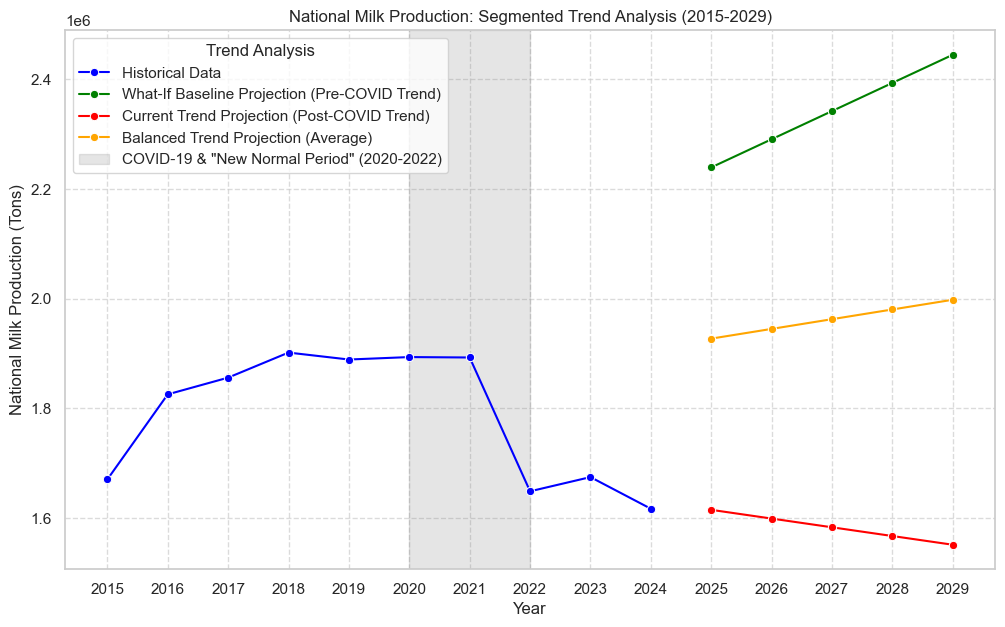

In [167]:
# Define future years for projection
future_years_df = pd.DataFrame({'Year': np.arange(2025, 2030)})

# 3.1 Generate two different projections using the two models
# IMPORTANT FIX: Only pass the 'Year' column to predict()
future_years_df['Predicted_Yield_Pre'] = model_pre.predict(future_years_df[['Year']])
future_years_df['Predicted_Yield_Post'] = model_post.predict(future_years_df[['Year']]) 
future_years_df['Predicted_Yield_Average'] = (future_years_df['Predicted_Yield_Pre'] + future_years_df['Predicted_Yield_Post']) / 2

# 3.2 Consolidate all data for plotting
# Historical data (2015-2024)
df_historical = df_national.copy()
df_historical['Type'] = 'Historical Data'

# Projection 1: Counterfactual (What-If Baseline)
df_projection_pre = future_years_df.rename(columns={'Predicted_Yield_Pre': 'National_Yield'})[['Year', 'National_Yield']]
df_projection_pre['Type'] = 'What-If Baseline Projection (Pre-COVID Trend)'

# Projection 2: Current Trend
df_projection_post = future_years_df.rename(columns={'Predicted_Yield_Post': 'National_Yield'})[['Year', 'National_Yield']]
df_projection_post['Type'] = 'Current Trend Projection (Post-COVID Trend)'

# Projection 3: Balanced Trend (Average of Pre and Post)
df_projection_avg = future_years_df.rename(columns={'Predicted_Yield_Average': 'National_Yield'})[['Year', 'National_Yield']]
df_projection_avg['Type'] = 'Balanced Trend Projection (Average)'

# Combine all series
df_plot = pd.concat([df_historical, df_projection_pre, df_projection_post, df_projection_avg], ignore_index=True)

# 3.3 Create the visualization
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_plot,
    x='Year',
    y='National_Yield',
    hue='Type',
    style='Type',
    marker='o',
    dashes=False,
    palette={
        'Historical Data': 'blue', 
        'What-If Baseline Projection (Pre-COVID Trend)': 'green', 
        'Current Trend Projection (Post-COVID Trend)': 'red',
        'Balanced Trend Projection (Average)': 'orange' # New color for the average
    }
)

# Highlight the shock period (2020-2021)
plt.axvspan(2020, 2022, color='gray', alpha=0.2, label='COVID-19 & "New Normal Period" (2020-2022)')
plt.legend(title='Trend Analysis', loc='upper left')

plt.title('National Milk Production: Segmented Trend Analysis (2015-2029)')
plt.ylabel('National Milk Production (Tons)')
plt.xlabel('Year')
plt.xticks(np.arange(2015, 2030, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
